In [1]:
%pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-macosx_10_9_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 868.0 kB/s eta 0:00:00 0:00:01
  Using cached tensorboard_data_server-0.7.2-py3-none-macosx_10_9_x86_64.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 M

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-06-05 22:21:50.470881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras import utils

dir = '/Users/hrohra/Documents/ml/imageclassification/notebooks/Bone Break Classification/Bone Break Classification/'
train_data = utils.image_dataset_from_directory(
    dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)

val_data = utils.image_dataset_from_directory(
    dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [4]:
class_names = train_data.class_names
class_names

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

2024-06-05 22:23:15.036925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


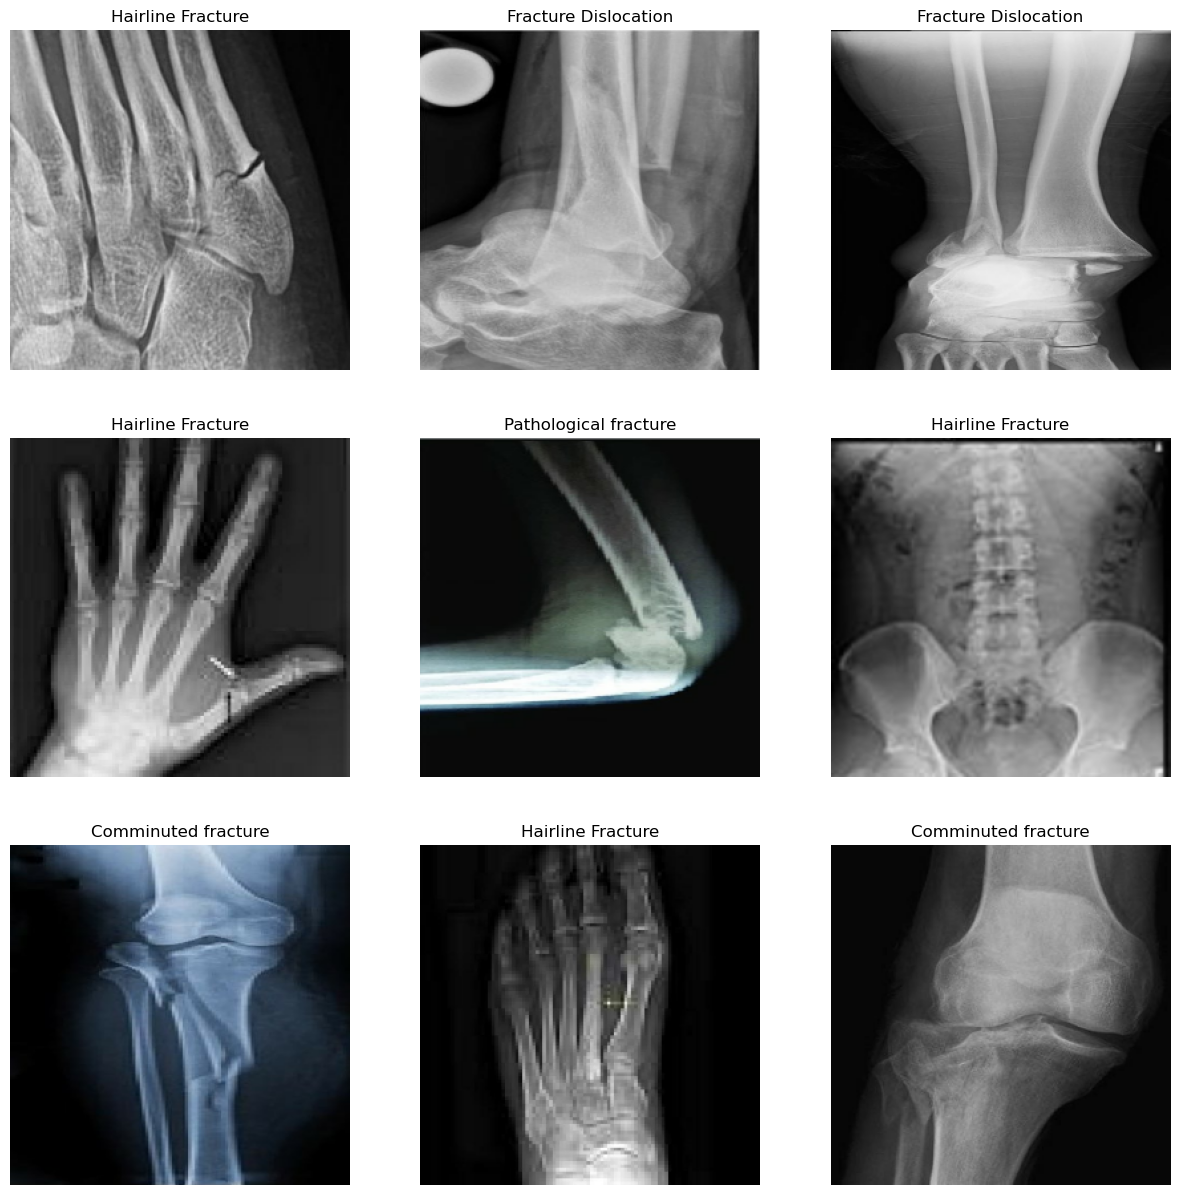

In [5]:
plt.figure(figsize=(15,15))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = AUTOTUNE)

In [7]:
x_train = []
y_train = []

for images, labels in train_data:
    x_train.append(images.numpy())
    y_train.append(labels.numpy())
x_train = np.concatenate(x_train, axis = 0)
print(x_train.shape)
y_train = np.concatenate(y_train, axis = 0)
print(y_train.shape) 

2024-06-05 22:23:58.931465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1017, 256, 256, 3)
(1017,)


In [8]:
x_val = []
x_test = []
y_val = []
y_test = []
test = False

for images, labels in val_data:
    if(not test):
        x_val.append(images.numpy())
        y_val.append(labels.numpy())
    else:
        x_test.append(images.numpy())
        y_test.append(labels.numpy())
    test = not test
x_val = np.concatenate(x_val, axis = 0)
y_val = np.concatenate(y_val, axis = 0)
print("Validation data shape:")
print("Images:- ",x_val.shape)
print("Labels:- ",y_val.shape)
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis = 0)
print("Test Data Shape: ")
print("Images:- ",x_test.shape)
print("Labels:- ",y_test.shape)

2024-06-05 22:24:27.614916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation data shape:
Images:-  (64, 256, 256, 3)
Labels:-  (64,)
Test Data Shape: 
Images:-  (48, 256, 256, 3)
Labels:-  (48,)


In [9]:
num_classes = len(class_names)
num_classes

10

In [10]:
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
y_val = utils.to_categorical(y_val, num_classes)

In [11]:
from tensorflow.keras import models

input_layer = layers.Input(shape=(256,256,3))
rescale_layer = layers.Rescaling(1./255, input_shape = (256,256,3))(input_layer)

x = layers.Conv2D(
    filters = 32,
    kernel_size = (3,3),
    strides = 2,
    padding = "same"
)(rescale_layer)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    filters = 32,
    kernel_size = (3,3),
    strides = 2,
    padding = "same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    filters = 32,
    kernel_size = (3,3),
    strides = 2,
    padding = "same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model = models.Model(input_layer, output_layer)
model.summary()

/usr/local/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     3,276,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,298,086 (12.58 MB)

 Trainable params: 3,297,694 (12.58 MB)

 Non-trainable params: 392 (1.53 KB)

In [12]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate = 0.0005)

model.compile(loss="categorical_crossentropy",optimizer = opt, metrics=['accuracy'])

In [13]:
history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1130 - loss: 2.8335 - val_accuracy: 0.1094 - val_loss: 2.4055
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3436 - loss: 1.9128 - val_accuracy: 0.4062 - val_loss: 1.8044
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5077 - loss: 1.5059 - val_accuracy: 0.6250 - val_loss: 1.2081
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6905 - loss: 1.0251 - val_accuracy: 0.8906 - val_loss: 0.7027
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8353 - loss: 0.6479 - val_accuracy: 0.8906 - val_loss: 0.5287
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9168 - loss: 0.4113 - val_accuracy: 0.9375 - val_loss: 0.3968
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9724 - loss: 0.2868 - val_accuracy: 0.9688 - val_loss: 0.2749
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9779 - loss: 0.1941 - val_accuracy: 0.9375 - val_loss:

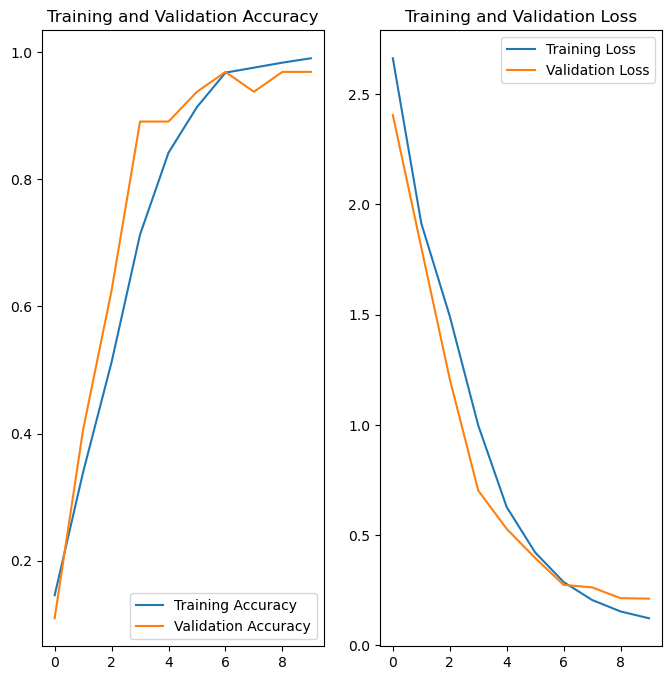

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Testing Results:")
print("Accuracy:- ",test_accuracy)
print("Loss:- ",test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.9132 - loss: 0.3339
Testing Results:
Accuracy:-  0.9166666865348816
Loss:-  0.3137383460998535
